## Introduction
The bike sharing dataset includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. The dataset being used in this analysis is limited to February 1, 2019 to March 1, 2019. As part of the data exploration, we will investigate various features included in this dataset in preparation for a more targeted report on the data.

## Preliminary Wrangling


In [52]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [53]:
# get the dat of week from a date time
def get_day_of_week(df, col):
    df['day_of_week'] = df[col].dt.day_of_week
    # make a list of days of week to replace the numbers (0-6) generated from the dt.day_of_week
    days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    # replace the numbered values with the strings of the days of the week
    df['day_of_week'] = df.day_of_week.replace(to_replace=[0, 1, 2, 3, 4, 5, 6], value=days_of_week)
    # make the days categorical types
    days = pd.api.types.CategoricalDtype(ordered=True, categories=days_of_week)
    # cast the days of week column as the days categorical type
    return df['day_of_week'].astype(days)

First, we'll load the data, making sure to parse the `start_time` and `end_time` as datetimes, and look at the structure of the data. There are multiple features in this dataset that are worth exploring. We can drop those that are not of any interest. 


In [54]:
# load the data and parse date columns as datetimes
bike_raw = pd.read_csv("data/201902-fordgobike-tripdata.csv", parse_dates=["start_time", "end_time"])
# examine the data structure
bike_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183412 non-null  int64         
 1   start_time               183412 non-null  datetime64[ns]
 2   end_time                 183412 non-null  datetime64[ns]
 3   start_station_id         183215 non-null  float64       
 4   start_station_name       183215 non-null  object        
 5   start_station_latitude   183412 non-null  float64       
 6   start_station_longitude  183412 non-null  float64       
 7   end_station_id           183215 non-null  float64       
 8   end_station_name         183215 non-null  object        
 9   end_station_latitude     183412 non-null  float64       
 10  end_station_longitude    183412 non-null  float64       
 11  bike_id                  183412 non-null  int64         
 12  user_type       

In [55]:
# drop the features that won't be explored
bike = bike_raw.drop(labels=['start_station_id', 'end_station_id'], axis=1)

One feature that will be worth exploring is what day of the week each rental took place. To do that, we need to extract the day of the week from the `start_time`.

In [56]:
# drop the features that won't be explored
bike = bike_raw.drop(labels=['start_station_id', 'end_station_id'], axis=1)
# get the day of the week from the datetime
bike["day_of_week"] = get_day_of_week(bike, "start_time")

Another interesting feature is which station start / end combinations are most popular. Do do that, we can create a new column containing the combination string.

In [57]:
# concatenate the start and end stations into one string to more easily analyze the station combinations
bike["station_combo"] = bike["start_station_name"] + "/" + bike["end_station_name"]

### What is the structure of your dataset?

The data contains information on the times and locations of the bike rentals along with information on the individual renting the bike. The data is largly categorical apart from the duration of the trip and the date/time that the rent started and ended. Because this data is largely categorical, there will likely be little use of scatter plots and heavier use of bar plots.

### What is/are the main feature(s) of interest in your dataset?

The main features of interest will be looking at relationships between the the bike users, stations, and times. 


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

The station names, user gender, type, start times, and duration will all be used to explore relationships between the stations, users, and times.

## Univariate Exploration

### What's the distribution of user types in the data?

Most of the users are "Subscribers" rather than "Customers". It's difficult to tell from the data / documentation what the difference between these types means. Best guess is that the company allows you to subscribe to get an unlimited or X number of rentals per month as well as an option to pay for a single use of a bike.

<AxesSubplot:xlabel='user_type', ylabel='count'>

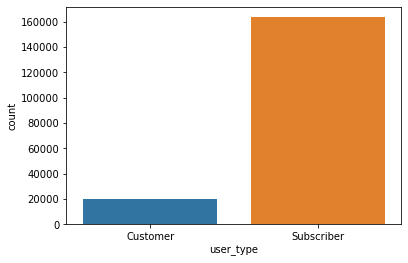

In [58]:
sns.countplot(data=bike, x="user_type")

### What's the distribution of ages in the data?

The birth year distribution peaks around 1990 (around 30 years old). Unsurprisingly, most of the distribution lies between 1960 and 2000 (ages 19-60). There appears to be some outliers with birth dates that are likely data entry errors. These can be cleaned up by limiting the birthdates to no earlier than 1940 (about 80 years old)

<AxesSubplot:xlabel='member_birth_year', ylabel='Count'>

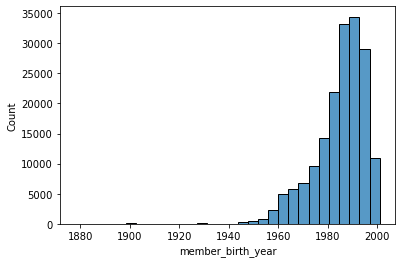

In [59]:
sns.histplot(data=bike, x="member_birth_year", bins=30)

In [60]:
# clean the birthdates that don't make sense by removing them from the data
bike = bike[bike['member_birth_year'] > 1940]

Now that the birth years are cleaned, we can look at the histogram again

<AxesSubplot:xlabel='member_birth_year', ylabel='Count'>

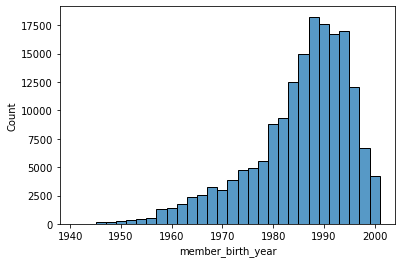

In [61]:
sns.histplot(data=bike, x="member_birth_year", bins=30)

### What's the distribution of gender in the data?

Most of the rentals in the data (over 120,000) are from males and about 4000 usages are from females. A small portion of the rentals are from users who identified as other. This data could be valuable for determining what kinds of bikes are needed to support the customer base.

<AxesSubplot:xlabel='member_gender', ylabel='count'>

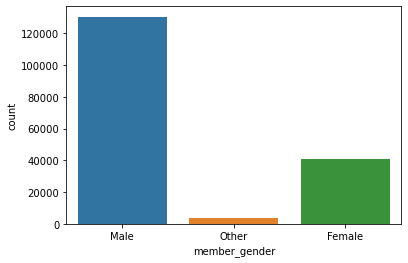

In [62]:
sns.countplot(data=bike, x="member_gender")

### What proportion of people are using the bike share for their entire trip?

Most of the bike rentals did not transport the user for the entirety of their trip. It's difficult to tell from the data/documentation if this includes walking or things like public transit and vehicles.

<AxesSubplot:xlabel='bike_share_for_all_trip', ylabel='count'>

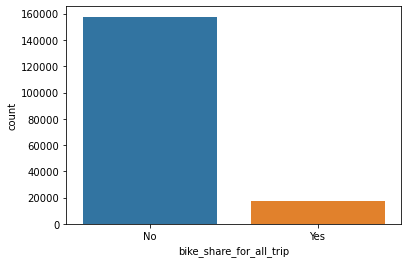

In [63]:
sns.countplot(data=bike, x="bike_share_for_all_trip")

### What is the duration of the trips made in the data?

It appears that the vast majority of the data is between 0 and 30 minutes (about 2000 seconds). There are outliers extending to around an hour and half.

<AxesSubplot:xlabel='duration_sec', ylabel='Count'>

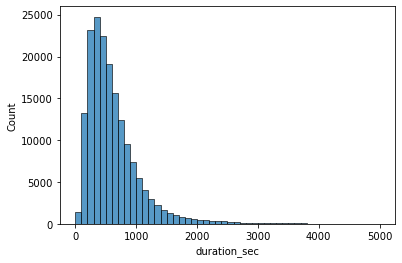

In [64]:
sns.histplot(data=bike, x="duration_sec", bins=50, binrange=(0, 5000))

### How many people are uses are the bikes getting for each day of the week?

It appears that there is a higher frequency of rentals during the week (Monday - Friday) than the weekend (Saturday - Sunday). This could be due to people using the bike sharing as a way to commute to work. It could be in the interest of the bike sharing company to to know how many bikes are needed at each station for a particular day of the week givin the cyclical demand.

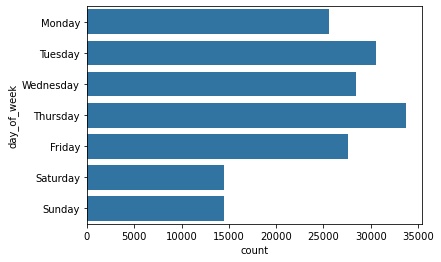

In [65]:
g = sns.countplot(data=bike, y="day_of_week", color=sns.color_palette()[0])

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

There were unusal birth years present that were cleaned by removing those rentals from the data. The variables most of interest are the gender distributions and the days of the week distribution. Those could be valuable for stocking stations for particular days.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The birth year distribution was highly skewed and included birth years that were likely data entry errors (1890). The data was cleaned by removing those observations from the dataset. It's not possible to know the correct ages, so removal seemed to be the best option

## Bivariate Exploration

### What is the distribution of durations between genders?

It appears that all genders have a very similar distribution, implying that there is no relationship between gender and duration time.

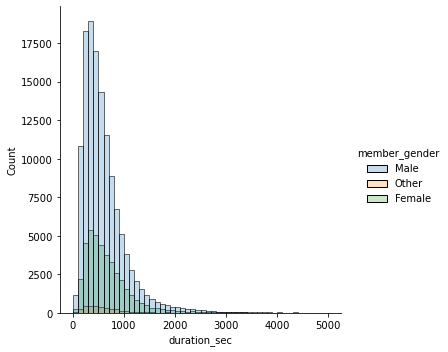

In [67]:
sns.displot(data=bike, x="duration_sec", bins=50, binrange=(0, 5000), kind="hist", hue="member_gender", alpha = .25)

### How does duration differ by gender?

After looking at the above distribution, we can  get a clearer picture with a boxplot on whether duration varies by gender. There doesn't appear to be any relationship between duration and gender. This plot gives a clearer picture of the lack of relationship than the histogram previously

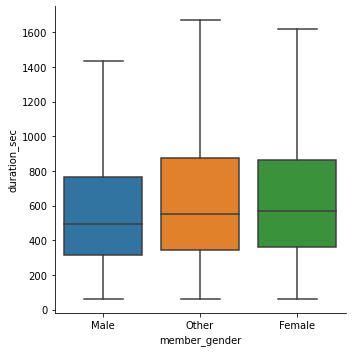

In [68]:
sns.catplot(data=bike, x="member_gender", y="duration_sec", kind="box", sym="")

### How does user type change over the course of a week?

The subscriber data follows a similar trend to the overall week distribution in the univariate section. However, the customer user type does not follow the same trend and the difference in customers between the days of the week are small enough and variable enough that there does not appear to be any interesting trends in the weekday data looking at different customer types.

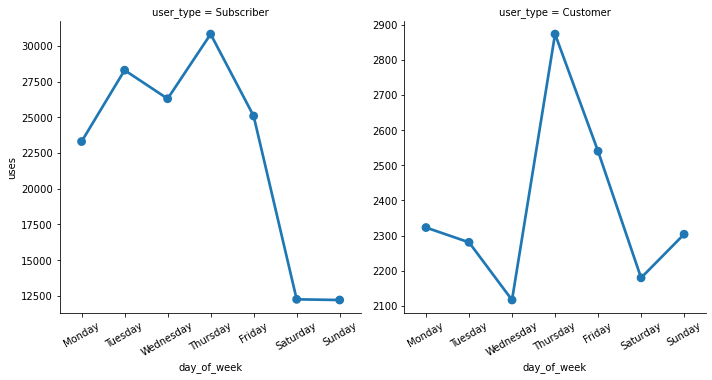

In [69]:
# facet the plots and free the y axis to get a clearer comparison of the distributions
day_users = bike[['day_of_week', 'user_type']].value_counts().rename("uses").reset_index()
g = sns.catplot(data=day_users, x="day_of_week", y="uses", col='user_type', kind="point", sharey=False)
g.set_xticklabels(rotation=30);

### How does duration time differ between customer types

Due to the large number of outliers, it's difficult to visualize the duration between customer types. Cutting out the outliers, it appears that customers use the bikes longer than subscribers, but the IQRs overlap, so it's hard to say from this visualization if there is a statistically significant trend.

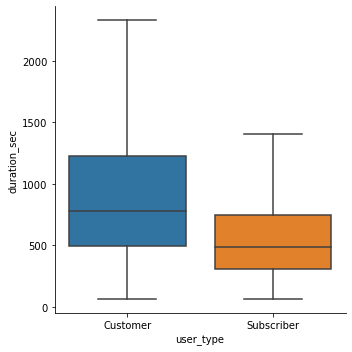

In [70]:
sns.catplot(data=bike, x="user_type", y="duration_sec", kind="box", sym="")

### How does duration of a trip change with birth year of user

The duration of the trips were tranformed to a log scale which shows a slight trend in younger users more likely to go on longer trips.

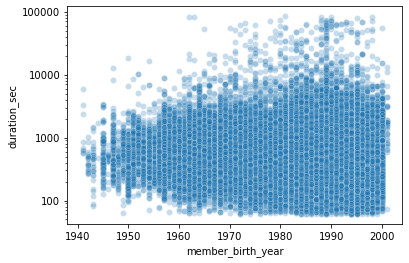

In [71]:
sns.scatterplot(data=bike, x="member_birth_year", y="duration_sec", alpha=0.25)
plt.yscale("log")

ticks= [100, 1000, 10000, 100000]
labels = ['{}'.format(v) for v in ticks]

plt.yticks(ticks, labels);

### Does birth year vary with user type?

There does not seem to be any trend with the user type and the birth year.

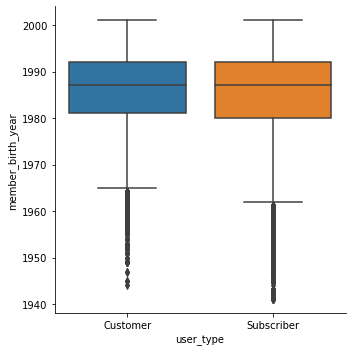

In [72]:
sns.catplot(data=bike, x="user_type", y="member_birth_year", kind="box")

### How many times per day are the most popular routes traveled?

The most popular station-to-station route, Berry St at 4th St and San Francisco Ferry Building is traveled about 14 times per day on average. The top 10 most popular routes are travelled at least 10 times per day on average for the month of data.

<AxesSubplot:xlabel='average_rentals_per_day', ylabel='station_combo'>

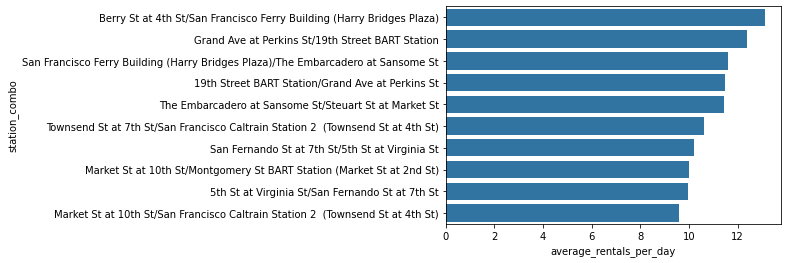

In [73]:
# count the number of rentals for each station combo and keep the top 10
station_combos = bike.value_counts("station_combo", sort=True).head(10).rename("num_rentals").reset_index()
# get the mean rentals per day (adding 1 to make it inclusive of the start/end dates)
station_combos['average_rentals_per_day'] = station_combos['num_rentals'] / (bike.start_time.max() - bike.start_time.min()).days + 1
sns.barplot(data=station_combos, y="station_combo", x="average_rentals_per_day", color=sns.color_palette()[0])

### What's the average duration between stations?

Looking at the stations with the largest mean duration between stations, the top ten routes have a mean duration of 10 to about 25 hours. 

<AxesSubplot:xlabel='mean_dur_hours', ylabel='station_combo'>

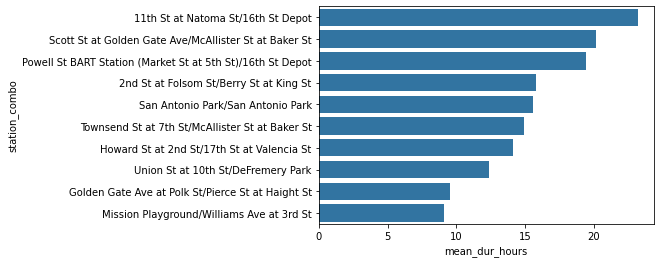

In [74]:
# get the mean duration for each station combo
station_combo_dur = bike.groupby("station_combo").duration_sec.mean().rename("mean_dur_secs").reset_index().sort_values("mean_dur_secs", ascending=False)
# convert from sec to hr
station_combo_dur['mean_dur_hours'] = station_combo_dur['mean_dur_secs'] / 60 / 60
sns.barplot(data=station_combo_dur.head(10), y="station_combo", x="mean_dur_hours", color=sns.color_palette()[0])

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

There doesn't appear to be any clear trend between gender and other features, however there does appear to be a trend in member age and the duration of the bike rental. Younger users tend to rent for a longer time than older users, however, the trend is slight and a majority of users rent the bikes for around the same amount of time. There may also be a slight trend in users designated as customers having the rentals for a longer duration than the users designated as subscribers. However, the IQRs overlap, so the trend is likely not statistically significant. A hypothesis test could be conducted to determine this if we wished to investigate this further.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

We were able to use some feature engineering to determine the number of rentals per day between station combinations. This could be further explored in combination with the lat/long data to map out the routes between stations color encoded by the average rentals per day in between each station combination. We will likely not investigate this further as it requires mapping packages.

## Multivariate Exploration

### How does the mean number of rentals by gender, vary per day of the week for the most popular starting stations?

Understanding how the number of rentals by gender varies per day of the week for the most popular stations can be useful for the company to ensure that the stations have the proper supply of the correct bike sizes to meet their customer demand. 

First, we can find the total number of rentals for each station start, gender, and day of the week in the dataset and filter to only look at the top six most used stations. Then, using seaborn's catplot and using the default mean estimator, we can use `num_rentals` to visualize the mean and standard error.

In [78]:
# get the date for each rental
bike["date"] = bike.start_time.dt.floor("D")
# count the number of rentals for each date, station, and gender
bike_rentals = bike.groupby(["start_station_name", "member_gender", "date"]).agg(num_rentals = ('start_time', 'count')).reset_index()
# get day of week for each date
bike_rentals["day_of_week"] = get_day_of_week(bike_rentals, "date")
# get the six stations with the most total rentals
top_six_stations = bike_rentals.groupby("start_station_name").num_rentals.sum().reset_index().sort_values("num_rentals", ascending=False).head(6).start_station_name.values 
# filter the bike rentals for the top six stations
top_six_station_rentals = bike_rentals[bike_rentals["start_station_name"].isin(top_six_stations)]

We can use a facet grid by station to see how the demand for each day of the week varies by gender. For instance, at the San Francisco Caltrain Station 2, there are a small fraction of rentals for both male and females during the weekend compared to weekdays, so that station doesn't need to be as stocked with as many bikes as it should during the week. Whereas the Market St at 10th St station doesn't see as large of a dropoff in female users during the weekend, so supply at that station should be about half what it is during the week to meet demand. We can also use the standard devation to get an idea of how much the demand varies for each day.

In [1]:
# catplot defaults to the mean estimator, so using num_re
g = sns.catplot(
    data=top_six_station_rentals, 
    x="day_of_week", y="num_rentals", 
    hue="member_gender", kind="point",
    hue_order=["Male", "Female", "Other"],
    col="start_station_name", 
    col_wrap=3,
    ci="sd"
);
g.legend.remove();
g.add_legend(title="Gender");
sns.move_legend(g, "upper right");
g.set_titles(col_template="{col_name}");
g.set(xlabel="Day of Week", ylabel="Mean Rentals");
g.set_xticklabels(rotation=30);

NameError: name 'sns' is not defined

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

The main interest in this section was to create a data visualization that allows for an analysis of the mean rentals broken down by gender for each day of the week, across all stations (but only focusing on the most popular stations). The trends shown in this multivariate visualization can help inform the company on how well each bike station should be stocked to support their customer demands such as the number of bikes needed at a particular station on a given day and bike sizes to support a certain number of males and females.

### Were there any interesting or surprising interactions between features?

All of the top stations showed a decrease in usage during the weekend, but some stations show a much more dramatic decrease than others, suggesting that some station may be much more utilized for work commutes. This information can help determine which stations need to be supplied with fewer bikes during the week and which ones need a fairly consistent number of bikes. For example, the Powell St BART Station only sees a small decrease in rentals from females during the weekend, suggesting that their supply of bikes that are better suited for female riders should remain relatively consistent throughout the week.

## Conclusions

In this analysis, a number of relationships were examined involving the rental stations, time/duration of the rental and user information. The analysis showed that more males than females tend to rent bikes, younger users have a slightly larger tendency for longer duration rentals, and the number of rentals tends to drop during the weekends, compared to weekdays. After putting together features for station name, gender, and using feature engineering to obtain the day of the week and the mean rentals per day of the week, we were able to create a visualization that can help to inform the bike sharing company on how their bike supplies should be stocked based on the station, day of the week, and gender of their users. This information is useful for keeping stations stocked with an adequate supply to meet customer demand. Given these conclusions, because this data only contains rentals in the month of February, the insights found in this analysis may not hold in other months of the year. We may expect to see different results if we were to analyze a month in the summer when the weather is warmer and many of these trends may differ if we analyzed data from another city.